# Experiment 1: Prompt Enhancement with Genetic Algorithms

## Goal
Evolve a basic prompt into an enhanced prompt using genetic algorithms.

## Methodology
- **Genome**: PromptGenome (base_prompt + positive_modifiers + negative_modifiers)
- **Fitness**: w1 * CLIP_score + w2 * Aesthetic_score
- **Model**: flux-schnell (Fal AI)

## Sub-experiments
- **1.1 Static Weights**: Fixed CLIP=0.6, Aesthetic=0.4 throughout evolution
- **1.2 Adaptive Weights**: CLIP weight decreases from 0.8 → 0.4 over generations

---

## Cell 1: Setup & Imports

In [1]:
# Standard library imports
import sys
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Add parent directory to path for src imports
sys.path.insert(0, '..')

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import scipy.stats as stats

# Project imports
from src.genome import PromptGenome, GenomeFactory
from src.evolution import GeneticOperators, EvolutionEngine
from src.fitness import FitnessEvaluator, AdaptiveFitnessEvaluator
from src.models import get_model
from src.utils import (
    create_modifier_vocab, 
    create_negative_vocab, 
    save_json,
    Logger
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Enable inline plotting
%matplotlib inline

print("Environment setup complete.")
print(f"Random seed: {RANDOM_SEED}")
print(f"Working directory: {os.getcwd()}")

Environment setup complete.
Random seed: 42
Working directory: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/experiments


## Cell 2: Configuration

In [2]:
# =============================================================================
# EXPERIMENT PARAMETERS
# =============================================================================

# Base prompt to evolve
BASE_PROMPT = "a professional product photo of a laptop"

# Evolution parameters
POPULATION_SIZE = 10
MAX_GENERATIONS = 20  # Start small for testing, increase for full experiment
ELITE_SIZE = 1
MUTATION_RATE = 0.4
ADD_PROBABILITY = 0.3
REMOVE_PROBABILITY = 0.2

# Genome constraints
MAX_POSITIVE_MODIFIERS = 8
MAX_NEGATIVE_MODIFIERS = 4

# =============================================================================
# FITNESS WEIGHTS
# =============================================================================

# Static weights (Experiment 1.1)
STATIC_CLIP_WEIGHT = 0.6
STATIC_AESTHETIC_WEIGHT = 0.4

# Adaptive weights (Experiment 1.2)
# Strategy: Start with semantic alignment, shift to aesthetic focus
INITIAL_CLIP_WEIGHT = 0.8  # Early: prioritize CLIP (semantic alignment)
FINAL_CLIP_WEIGHT = 0.4    # Late: prioritize aesthetics

# =============================================================================
# MODEL SETTINGS
# =============================================================================

MODEL_NAME = "flux-schnell"
IMAGE_SIZE = "landscape_4_3"
NUM_INFERENCE_STEPS = 4
GENERATION_SEED = 42  # Fixed seed for reproducible image generation

# =============================================================================
# OUTPUT SETTINGS
# =============================================================================

OUTPUT_DIR = Path("../data/results/experiment_1")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_EVERY_N_GENERATIONS = 5  # Save checkpoints every N generations

# Print configuration summary
print("=" * 60)
print("EXPERIMENT 1 CONFIGURATION")
print("=" * 60)
print(f"\nBase Prompt: {BASE_PROMPT}")
print(f"\nEvolution Parameters:")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Max Generations: {MAX_GENERATIONS}")
print(f"  Elite Size: {ELITE_SIZE}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print(f"\nStatic Weights (Exp 1.1):")
print(f"  CLIP: {STATIC_CLIP_WEIGHT}, Aesthetic: {STATIC_AESTHETIC_WEIGHT}")
print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  CLIP: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"\nModel: {MODEL_NAME}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 60)

EXPERIMENT 1 CONFIGURATION

Base Prompt: a professional product photo of a laptop

Evolution Parameters:
  Population Size: 10
  Max Generations: 20
  Elite Size: 1
  Mutation Rate: 0.4

Static Weights (Exp 1.1):
  CLIP: 0.6, Aesthetic: 0.4

Adaptive Weights (Exp 1.2):
  CLIP: 0.8 -> 0.4

Model: flux-schnell
Output Directory: ../data/results/experiment_1


## Cell 3: Initialize Components

In [3]:
# =============================================================================
# INITIALIZE MODEL
# =============================================================================
print("Initializing image generation model...")
model = get_model(MODEL_NAME)
print(f"  Model: {MODEL_NAME} initialized")

# =============================================================================
# CREATE VOCABULARIES
# =============================================================================
print("\nCreating vocabularies...")
modifier_vocab = create_modifier_vocab()
negative_vocab = create_negative_vocab()
print(f"  Positive modifiers: {len(modifier_vocab)} terms")
print(f"  Negative modifiers: {len(negative_vocab)} terms")

# Preview some modifiers
print(f"\n  Sample positive modifiers: {modifier_vocab[:5]}")
print(f"  Sample negative modifiers: {negative_vocab[:5]}")

# =============================================================================
# CREATE GENOME FACTORY
# =============================================================================
print("\nCreating genome factory...")
factory = GenomeFactory(
    modifier_vocab=modifier_vocab,
    negative_vocab=negative_vocab,
    max_positive_modifiers=MAX_POSITIVE_MODIFIERS,
    max_negative_modifiers=MAX_NEGATIVE_MODIFIERS
)
print(f"  Max positive modifiers: {MAX_POSITIVE_MODIFIERS}")
print(f"  Max negative modifiers: {MAX_NEGATIVE_MODIFIERS}")

# =============================================================================
# CREATE GENETIC OPERATORS
# =============================================================================
print("\nCreating genetic operators...")
operators = GeneticOperators(
    factory=factory,
    mutation_rate=MUTATION_RATE,
    add_probability=ADD_PROBABILITY,
    remove_probability=REMOVE_PROBABILITY
)
print(f"  Mutation rate: {MUTATION_RATE}")
print(f"  Add probability: {ADD_PROBABILITY}")
print(f"  Remove probability: {REMOVE_PROBABILITY}")

# =============================================================================
# CREATE EVOLUTION ENGINE
# =============================================================================
print("\nCreating evolution engine...")
engine = EvolutionEngine(
    factory=factory,
    operators=operators,
    population_size=POPULATION_SIZE,
    elite_size=ELITE_SIZE,
    selection_method="tournament"
)
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Elite size: {ELITE_SIZE}")
print(f"  Selection method: tournament")

# =============================================================================
# CREATE FITNESS EVALUATORS
# =============================================================================
print("\nCreating fitness evaluators...")

# Static fitness evaluator (Experiment 1.1)
static_evaluator = FitnessEvaluator(
    clip_weight=STATIC_CLIP_WEIGHT,
    aesthetic_weight=STATIC_AESTHETIC_WEIGHT
)
print(f"  Static Evaluator: CLIP={STATIC_CLIP_WEIGHT}, Aesthetic={STATIC_AESTHETIC_WEIGHT}")

# Adaptive fitness evaluator (Experiment 1.2)
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)
print(f"  Adaptive Evaluator: CLIP {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")

# =============================================================================
# INITIALIZE LOGGER
# =============================================================================
logger = Logger(log_dir=str(OUTPUT_DIR / "logs"), name="experiment_1")
logger.info("Experiment 1 components initialized")

print("\n" + "=" * 60)
print("ALL COMPONENTS INITIALIZED SUCCESSFULLY")
print("=" * 60)

Initializing image generation model...
  Model: flux-schnell initialized

Creating vocabularies...
  Positive modifiers: 58 terms
  Negative modifiers: 24 terms

  Sample positive modifiers: ['8k', '4k', 'high resolution', 'highly detailed', 'sharp focus']
  Sample negative modifiers: ['blurry', 'distorted', 'low quality', 'bad quality', 'worst quality']

Creating genome factory...
  Max positive modifiers: 8
  Max negative modifiers: 4

Creating genetic operators...
  Mutation rate: 0.4
  Add probability: 0.3
  Remove probability: 0.2

Creating evolution engine...
  Population size: 10
  Elite size: 1
  Selection method: tournament

Creating fitness evaluators...
Initializing CLIP model on cpu...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully
  Static Evaluator: CLIP=0.6, Aesthetic=0.4
Initializing CLIP model on cpu...


2025-12-30 12:07:39,643 - experiment_1 - INFO - Experiment 1 components initialized


CLIP model loaded successfully
  Adaptive Evaluator: CLIP 0.8 -> 0.4

ALL COMPONENTS INITIALIZED SUCCESSFULLY


## Cell 4: Baseline Evaluation

Generating baseline image (no modifiers)...
Prompt: a professional product photo of a laptop

Baseline genome: PromptGenome(fitness=0.000, prompt='a professional product photo of a laptop')
Baseline image generated successfully.

Evaluating baseline fitness...
CLIP score: 0.6601
Aesthetic score: 0.8146
Weighted fitness: 0.7219

Baseline Fitness Score: 0.7219
Baseline image saved to: ../data/results/experiment_1/baseline_image.jpg


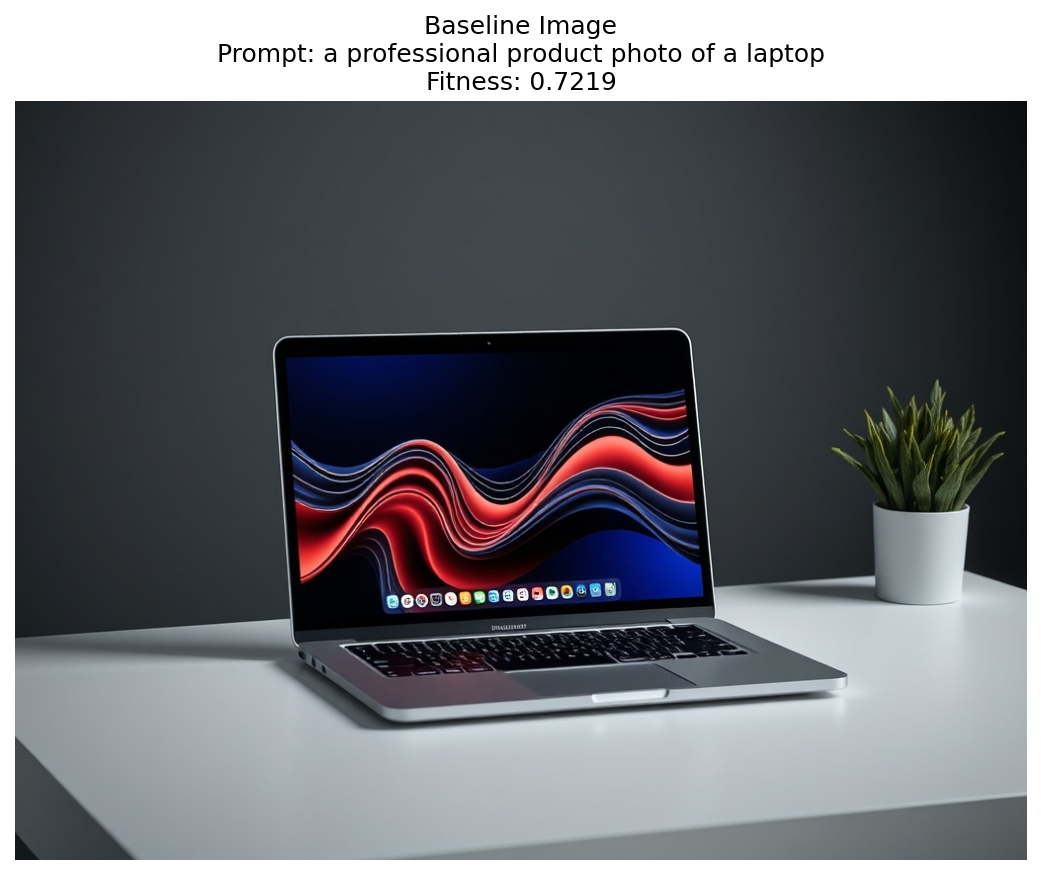

2025-12-30 12:07:49,515 - experiment_1 - INFO - Baseline evaluation complete. Score: 0.7219


In [4]:
# =============================================================================
# GENERATE AND EVALUATE BASELINE
# =============================================================================
print("Generating baseline image (no modifiers)...")
print(f"Prompt: {BASE_PROMPT}")
print()

# Create baseline genome (empty modifiers)
baseline_genome = factory.create_empty(BASE_PROMPT)
print(f"Baseline genome: {baseline_genome}")

# Generate baseline image
try:
    baseline_image, baseline_metadata = model.generate(
        prompt=baseline_genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=GENERATION_SEED
    )
    print("Baseline image generated successfully.")
except Exception as e:
    print(f"Error generating baseline image: {e}")
    raise

# Evaluate baseline fitness using static evaluator
print("\nEvaluating baseline fitness...")
baseline_score = static_evaluator.evaluate(
    image=baseline_image, 
    text=BASE_PROMPT, 
    verbose=True
)
print(f"\nBaseline Fitness Score: {baseline_score:.4f}")

# Save baseline image
baseline_path = OUTPUT_DIR / "baseline_image.jpg"
baseline_image.save(baseline_path)
print(f"Baseline image saved to: {baseline_path}")

# Display baseline image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(baseline_image)
ax.set_title(f"Baseline Image\nPrompt: {BASE_PROMPT}\nFitness: {baseline_score:.4f}", fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "baseline_display.png")
plt.show()

# Log baseline results
logger.info(f"Baseline evaluation complete. Score: {baseline_score:.4f}")

## Cell 5: Helper Functions

In [5]:
def run_experiment(
    evaluator: FitnessEvaluator,
    experiment_name: str,
    max_generations: int = MAX_GENERATIONS,
    save_every: int = SAVE_EVERY_N_GENERATIONS,
    is_adaptive: bool = False
) -> Tuple[Dict[str, Any], List[PromptGenome]]:
    """
    Run one complete evolutionary experiment.
    
    Args:
        evaluator: Fitness evaluator (static or adaptive)
        experiment_name: Name for saving results
        max_generations: Maximum number of generations
        save_every: Save checkpoint every N generations
        is_adaptive: Whether using adaptive evaluator
    
    Returns:
        history: Dict with fitness tracking per generation
        final_population: Final evolved population
    """
    # Create experiment output directory
    exp_dir = OUTPUT_DIR / experiment_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': [],
        'diversity': [],
        'best_prompts': [],
        'clip_weights': [],  # Track weight changes for adaptive
        'aesthetic_weights': []
    }
    
    # Initialize population
    print(f"Initializing population of {POPULATION_SIZE} genomes...")
    population = engine.initialize_population(BASE_PROMPT)
    
    # Store images for visualization
    generation_images = {}
    
    # Evolution loop
    for generation in range(max_generations):
        print(f"\n--- Generation {generation + 1}/{max_generations} ---")
        
        # Update adaptive weights if using adaptive evaluator
        if is_adaptive:
            evaluator.update_generation(generation)
            current_clip_weight = evaluator.clip_weight
            current_aesthetic_weight = evaluator.aesthetic_weight
        else:
            current_clip_weight = STATIC_CLIP_WEIGHT
            current_aesthetic_weight = STATIC_AESTHETIC_WEIGHT
        
        history['clip_weights'].append(current_clip_weight)
        history['aesthetic_weights'].append(current_aesthetic_weight)
        
        print(f"Weights: CLIP={current_clip_weight:.2f}, Aesthetic={current_aesthetic_weight:.2f}")
        
        # Evaluate fitness for all genomes
        gen_images = []
        for idx, genome in enumerate(tqdm(population, desc="Evaluating population")):
            try:
                # Generate image
                image, metadata = model.generate(
                    prompt=genome.to_prompt(),
                    image_size=IMAGE_SIZE,
                    num_inference_steps=NUM_INFERENCE_STEPS,
                    seed=GENERATION_SEED + generation * 100 + idx  # Varied but reproducible
                )
                
                # Evaluate fitness
                genome.fitness = evaluator.evaluate(image, BASE_PROMPT)
                gen_images.append((genome.fitness, image, genome.to_prompt()))
                
            except Exception as e:
                print(f"Error evaluating genome {idx}: {e}")
                genome.fitness = 0.0
        
        # Track fitness statistics
        fitnesses = [g.fitness for g in population]
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        worst_fitness = min(fitnesses)
        diversity = engine.get_diversity(population)
        
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['worst_fitness'].append(worst_fitness)
        history['diversity'].append(diversity)
        
        # Get best genome
        best_genome = engine.get_best(population)
        history['best_prompts'].append(best_genome.to_prompt())
        
        print(f"Best: {best_fitness:.4f} | Avg: {avg_fitness:.4f} | Diversity: {diversity:.2f}")
        print(f"Best prompt: {best_genome.to_prompt()[:80]}...")
        
        # Save checkpoint
        if (generation + 1) % save_every == 0 or generation == max_generations - 1:
            checkpoint_dir = exp_dir / f"gen_{generation + 1:02d}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            # Save best image
            if gen_images:
                gen_images.sort(key=lambda x: x[0], reverse=True)
                best_img = gen_images[0][1]
                best_img.save(checkpoint_dir / "best_image.jpg")
                generation_images[generation] = best_img
            
            # Save checkpoint data
            checkpoint_data = {
                'generation': generation + 1,
                'best_fitness': best_fitness,
                'avg_fitness': avg_fitness,
                'best_prompt': best_genome.to_prompt(),
                'best_modifiers': best_genome.positive_modifiers,
                'best_negative': best_genome.negative_modifiers
            }
            save_json(checkpoint_data, str(checkpoint_dir / "checkpoint.json"))
            print(f"Checkpoint saved to {checkpoint_dir}")
        
        # Evolve to next generation (except on last generation)
        if generation < max_generations - 1:
            population = engine.evolve_generation(population)
    
    # Save final results
    final_results = {
        'experiment_name': experiment_name,
        'generations': max_generations,
        'final_best_fitness': history['best_fitness'][-1],
        'final_avg_fitness': history['avg_fitness'][-1],
        'history': history
    }
    save_json(final_results, str(exp_dir / "final_results.json"))
    
    logger.info(f"{experiment_name} complete. Best fitness: {history['best_fitness'][-1]:.4f}")
    
    return history, population


def visualize_results(history: Dict[str, List], baseline_score: float, title: str = "Evolution Progress"):
    """
    Create publication-quality convergence plot.
    
    Args:
        history: Dict with best_fitness, avg_fitness, worst_fitness per generation
        baseline_score: Baseline fitness for comparison
        title: Plot title
    """
    generations = range(1, len(history['best_fitness']) + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot fitness curves
    ax.plot(generations, history['best_fitness'], 'g-', linewidth=2, 
            label='Best Fitness', marker='o', markersize=4)
    ax.plot(generations, history['avg_fitness'], 'b--', linewidth=1.5,
            label='Average Fitness', alpha=0.8)
    ax.fill_between(generations, history['worst_fitness'], history['best_fitness'],
                    alpha=0.2, color='green', label='Fitness Range')
    
    # Baseline reference line
    ax.axhline(y=baseline_score, color='orange', linestyle='-.', 
               linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    # Labels and formatting
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(generations))
    
    # Set y-axis to start from 0 or slightly below minimum
    y_min = min(min(history['worst_fitness']), baseline_score) * 0.95
    y_max = max(history['best_fitness']) * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig


def compare_experiments(
    exp1_history: Dict[str, List],
    exp2_history: Dict[str, List],
    baseline_score: float,
    exp1_name: str = "Static Weights",
    exp2_name: str = "Adaptive Weights"
):
    """
    Create side-by-side comparison plot for two experiments.
    
    Args:
        exp1_history: History dict from experiment 1
        exp2_history: History dict from experiment 2
        baseline_score: Baseline fitness
        exp1_name: Label for experiment 1
        exp2_name: Label for experiment 2
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = range(1, len(exp1_history['best_fitness']) + 1)
    
    # Left plot: Fitness comparison
    ax1 = axes[0]
    ax1.plot(generations, exp1_history['best_fitness'], 'b-', linewidth=2,
             label=f'{exp1_name} (Best)', marker='o', markersize=4)
    ax1.plot(generations, exp2_history['best_fitness'], 'r-', linewidth=2,
             label=f'{exp2_name} (Best)', marker='s', markersize=4)
    ax1.axhline(y=baseline_score, color='orange', linestyle='-.', 
                linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness Score')
    ax1.set_title('Best Fitness Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Weight evolution (for adaptive)
    ax2 = axes[1]
    ax2.plot(generations, exp1_history['clip_weights'], 'b--', linewidth=2,
             label=f'{exp1_name} CLIP Weight')
    ax2.plot(generations, exp2_history['clip_weights'], 'r-', linewidth=2,
             label=f'{exp2_name} CLIP Weight')
    ax2.plot(generations, exp2_history['aesthetic_weights'], 'r:', linewidth=2,
             label=f'{exp2_name} Aesthetic Weight')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Weight Value')
    ax2.set_title('Fitness Weight Evolution')
    ax2.legend(loc='center right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig


def generate_final_image(genome: PromptGenome, seed: int = GENERATION_SEED) -> Tuple[Image.Image, float]:
    """
    Generate final image for a genome with consistent seed.
    
    Args:
        genome: PromptGenome to generate image from
        seed: Random seed for reproducibility
    
    Returns:
        image: Generated PIL Image
        fitness: Fitness score
    """
    image, _ = model.generate(
        prompt=genome.to_prompt(),
        image_size=IMAGE_SIZE,
        num_inference_steps=NUM_INFERENCE_STEPS,
        seed=seed
    )
    fitness = static_evaluator.evaluate(image, BASE_PROMPT)
    return image, fitness


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Cell 6: Run Experiment 1.1 (Static Weights)

In [6]:
print("=" * 60)
print("EXPERIMENT 1.1: STATIC WEIGHTS")
print(f"CLIP Weight: {STATIC_CLIP_WEIGHT} (fixed)")
print(f"Aesthetic Weight: {STATIC_AESTHETIC_WEIGHT} (fixed)")
print("=" * 60)

# Run experiment with static weights
static_history, static_population = run_experiment(
    evaluator=static_evaluator,
    experiment_name="exp1_1_static",
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=False
)

# Get best genome from static experiment
best_static_genome = max(static_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.1 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_static_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_static_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_static_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_static_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_static_genome.negative_modifiers}")

EXPERIMENT 1.1: STATIC WEIGHTS
CLIP Weight: 0.6 (fixed)
Aesthetic Weight: 0.4 (fixed)
Initializing population of 10 genomes...

--- Generation 1/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Best: 0.7586 | Avg: 0.7294 | Diversity: 0.48
Best prompt: a professional product photo of a laptop, aerial view...

--- Generation 2/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7390 | Avg: 0.7172 | Diversity: 0.45
Best prompt: a professional product photo of a laptop, professional, golden hour, muted color...

--- Generation 3/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7546 | Avg: 0.7229 | Diversity: 0.46
Best prompt: a professional product photo of a laptop...

--- Generation 4/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7514 | Avg: 0.7228 | Diversity: 0.34
Best prompt: a professional product photo of a laptop, motion blur, high resolution, cool ton...

--- Generation 5/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7555 | Avg: 0.7327 | Diversity: 0.49
Best prompt: a professional product photo of a laptop, high resolution, pixar style, backlit...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7477 | Avg: 0.7206 | Diversity: 0.55
Best prompt: a professional product photo of a laptop, centered composition, pixar style, con...

--- Generation 7/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7420 | Avg: 0.7213 | Diversity: 0.44
Best prompt: a professional product photo of a laptop, centered composition, pixar style, con...

--- Generation 8/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7498 | Avg: 0.7302 | Diversity: 0.40
Best prompt: a professional product photo of a laptop, cool tones, close-up, depth of field, ...

--- Generation 9/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7517 | Avg: 0.7256 | Diversity: 0.52
Best prompt: a professional product photo of a laptop, HDR, close-up, depth of field, lens fl...

--- Generation 10/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7448 | Avg: 0.7176 | Diversity: 0.55
Best prompt: a professional product photo of a laptop, HDR, close-up, depth of field, lens fl...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_10

--- Generation 11/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7564 | Avg: 0.7219 | Diversity: 0.59
Best prompt: a professional product photo of a laptop, portrait, masterpiece, best quality, 4...

--- Generation 12/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7402 | Avg: 0.7299 | Diversity: 0.49
Best prompt: a professional product photo of a laptop...

--- Generation 13/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7488 | Avg: 0.7266 | Diversity: 0.43
Best prompt: a professional product photo of a laptop, fantasy art, natural lighting, soft li...

--- Generation 14/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7447 | Avg: 0.7244 | Diversity: 0.23
Best prompt: a professional product photo of a laptop, soft lighting, photorealistic...

--- Generation 15/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7566 | Avg: 0.7209 | Diversity: 0.30
Best prompt: a professional product photo of a laptop...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7420 | Avg: 0.7173 | Diversity: 0.29
Best prompt: a professional product photo of a laptop...

--- Generation 17/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7550 | Avg: 0.7272 | Diversity: 0.37
Best prompt: a professional product photo of a laptop...

--- Generation 18/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7500 | Avg: 0.7263 | Diversity: 0.37
Best prompt: a professional product photo of a laptop, natural lighting, photorealistic, best...

--- Generation 19/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7533 | Avg: 0.7273 | Diversity: 0.45
Best prompt: a professional product photo of a laptop, natural lighting, side lighting, sharp...

--- Generation 20/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 12:14:43,184 - experiment_1 - INFO - exp1_1_static complete. Best fitness: 0.7467


Best: 0.7467 | Avg: 0.7289 | Diversity: 0.57
Best prompt: a professional product photo of a laptop, concept art, dreamy, rule of thirds, s...
Checkpoint saved to ../data/results/experiment_1/exp1_1_static/gen_20

EXPERIMENT 1.1 RESULTS
Final Best Fitness: 0.7467
Improvement over baseline: 3.44%

Best Prompt:
  a professional product photo of a laptop, concept art, dreamy, rule of thirds, sharp focus, depth of field, lens flare, warm tones, bird's eye view

Positive Modifiers: ['concept art', 'dreamy', 'rule of thirds', 'sharp focus', 'depth of field', 'lens flare', 'warm tones', "bird's eye view"]
Negative Modifiers: ['low quality', 'bad anatomy', 'pixelated', 'grainy']


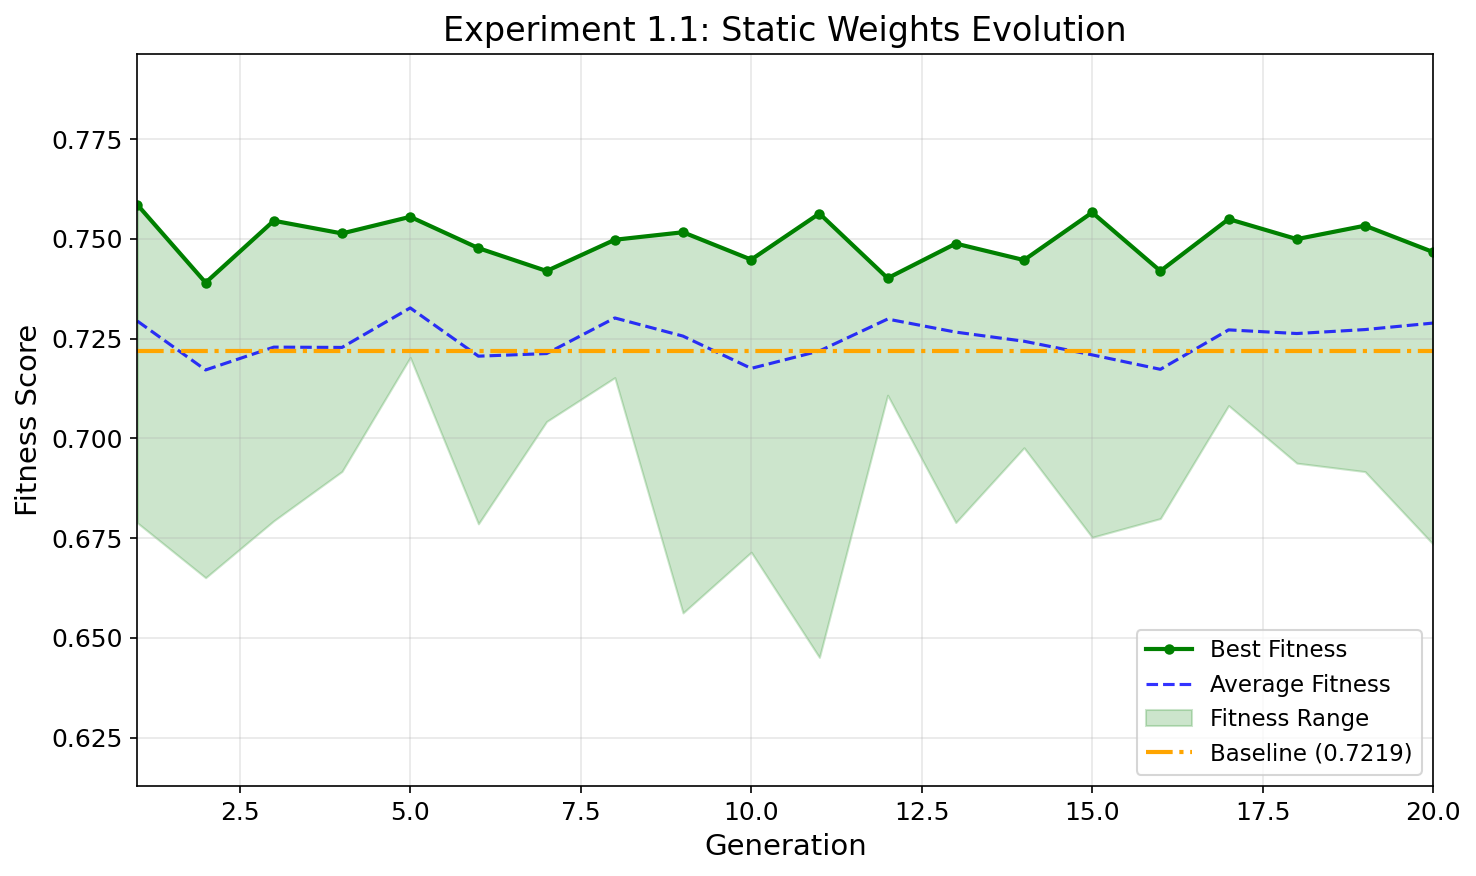

In [7]:
# Visualize static experiment convergence
fig_static = visualize_results(
    static_history, 
    baseline_score,
    title="Experiment 1.1: Static Weights Evolution"
)
fig_static.savefig(OUTPUT_DIR / "exp1_1_convergence.png")
plt.show()

## Cell 7: Run Experiment 1.2 (Adaptive Weights)

In [8]:
print("=" * 60)
print("EXPERIMENT 1.2: ADAPTIVE WEIGHTS")
print(f"CLIP Weight: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"Aesthetic Weight: {1 - INITIAL_CLIP_WEIGHT} -> {1 - FINAL_CLIP_WEIGHT}")
print("Strategy: Start semantic-focused, end aesthetic-focused")
print("=" * 60)

# Re-create adaptive evaluator to reset state
adaptive_evaluator = AdaptiveFitnessEvaluator(
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)

# Run experiment with adaptive weights
adaptive_history, adaptive_population = run_experiment(
    evaluator=adaptive_evaluator,
    experiment_name="exp1_2_adaptive",
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=True
)

# Get best genome from adaptive experiment
best_adaptive_genome = max(adaptive_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 1.2 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_adaptive_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_adaptive_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"\nPositive Modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"Negative Modifiers: {best_adaptive_genome.negative_modifiers}")

EXPERIMENT 1.2: ADAPTIVE WEIGHTS
CLIP Weight: 0.8 -> 0.4
Aesthetic Weight: 0.19999999999999996 -> 0.6
Strategy: Start semantic-focused, end aesthetic-focused
Initializing CLIP model on cpu...
CLIP model loaded successfully
Initializing population of 10 genomes...

--- Generation 1/20 ---
Weights: CLIP=0.80, Aesthetic=0.20


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7005 | Avg: 0.6817 | Diversity: 0.65
Best prompt: a professional product photo of a laptop, 4k, watercolor, portrait, golden hour,...

--- Generation 2/20 ---
Weights: CLIP=0.78, Aesthetic=0.22


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7033 | Avg: 0.6729 | Diversity: 0.54
Best prompt: a professional product photo of a laptop, 4k, watercolor, studio ghibli style, g...

--- Generation 3/20 ---
Weights: CLIP=0.76, Aesthetic=0.24


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7061 | Avg: 0.6940 | Diversity: 0.45
Best prompt: a professional product photo of a laptop, 4k, watercolor, studio ghibli style, g...

--- Generation 4/20 ---
Weights: CLIP=0.74, Aesthetic=0.26


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7153 | Avg: 0.6998 | Diversity: 0.40
Best prompt: a professional product photo of a laptop, 4k, watercolor, studio ghibli style, g...

--- Generation 5/20 ---
Weights: CLIP=0.72, Aesthetic=0.28


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7149 | Avg: 0.7058 | Diversity: 0.45
Best prompt: a professional product photo of a laptop, illustration, watercolor, oil painting...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_05

--- Generation 6/20 ---
Weights: CLIP=0.70, Aesthetic=0.30


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7294 | Avg: 0.7081 | Diversity: 0.45
Best prompt: a professional product photo of a laptop, oil painting...

--- Generation 7/20 ---
Weights: CLIP=0.68, Aesthetic=0.32


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7365 | Avg: 0.7156 | Diversity: 0.50
Best prompt: a professional product photo of a laptop, cool tones...

--- Generation 8/20 ---
Weights: CLIP=0.66, Aesthetic=0.34


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7249 | Avg: 0.7127 | Diversity: 0.50
Best prompt: a professional product photo of a laptop, centered composition, warm tones, vibr...

--- Generation 9/20 ---
Weights: CLIP=0.64, Aesthetic=0.36


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7422 | Avg: 0.7179 | Diversity: 0.50
Best prompt: a professional product photo of a laptop, centered composition, warm tones, HDR,...

--- Generation 10/20 ---
Weights: CLIP=0.62, Aesthetic=0.38


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7344 | Avg: 0.7241 | Diversity: 0.61
Best prompt: a professional product photo of a laptop, long exposure...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_10

--- Generation 11/20 ---
Weights: CLIP=0.60, Aesthetic=0.40


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7530 | Avg: 0.7298 | Diversity: 0.59
Best prompt: a professional product photo of a laptop, studio lighting, warm tones, HDR, rule...

--- Generation 12/20 ---
Weights: CLIP=0.58, Aesthetic=0.42


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7513 | Avg: 0.7270 | Diversity: 0.61
Best prompt: a professional product photo of a laptop, bird's eye view, anime style...

--- Generation 13/20 ---
Weights: CLIP=0.56, Aesthetic=0.44


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7604 | Avg: 0.7444 | Diversity: 0.60
Best prompt: a professional product photo of a laptop, bokeh, studio lighting, ethereal, high...

--- Generation 14/20 ---
Weights: CLIP=0.54, Aesthetic=0.46


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7709 | Avg: 0.7442 | Diversity: 0.57
Best prompt: a professional product photo of a laptop, bokeh, studio lighting, ethereal, high...

--- Generation 15/20 ---
Weights: CLIP=0.52, Aesthetic=0.48


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7675 | Avg: 0.7288 | Diversity: 0.54
Best prompt: a professional product photo of a laptop...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_15

--- Generation 16/20 ---
Weights: CLIP=0.50, Aesthetic=0.50


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7679 | Avg: 0.7358 | Diversity: 0.50
Best prompt: a professional product photo of a laptop...

--- Generation 17/20 ---
Weights: CLIP=0.48, Aesthetic=0.52


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7865 | Avg: 0.7442 | Diversity: 0.45
Best prompt: a professional product photo of a laptop...

--- Generation 18/20 ---
Weights: CLIP=0.46, Aesthetic=0.54


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7752 | Avg: 0.7466 | Diversity: 0.44
Best prompt: a professional product photo of a laptop, best quality, oil painting, rule of th...

--- Generation 19/20 ---
Weights: CLIP=0.44, Aesthetic=0.56


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.7988 | Avg: 0.7572 | Diversity: 0.55
Best prompt: a professional product photo of a laptop, best quality, oil painting, rule of th...

--- Generation 20/20 ---
Weights: CLIP=0.42, Aesthetic=0.58


Evaluating population:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 12:22:17,746 - experiment_1 - INFO - exp1_2_adaptive complete. Best fitness: 0.7907


Best: 0.7907 | Avg: 0.7537 | Diversity: 0.66
Best prompt: a professional product photo of a laptop, photorealistic, oil painting, rule of ...
Checkpoint saved to ../data/results/experiment_1/exp1_2_adaptive/gen_20

EXPERIMENT 1.2 RESULTS
Final Best Fitness: 0.7907
Improvement over baseline: 9.54%

Best Prompt:
  a professional product photo of a laptop, photorealistic, oil painting, rule of thirds, rim lighting, golden hour, professional

Positive Modifiers: ['photorealistic', 'oil painting', 'rule of thirds', 'rim lighting', 'golden hour', 'professional']
Negative Modifiers: ['text', 'bad proportions', 'bad anatomy', 'disfigured']


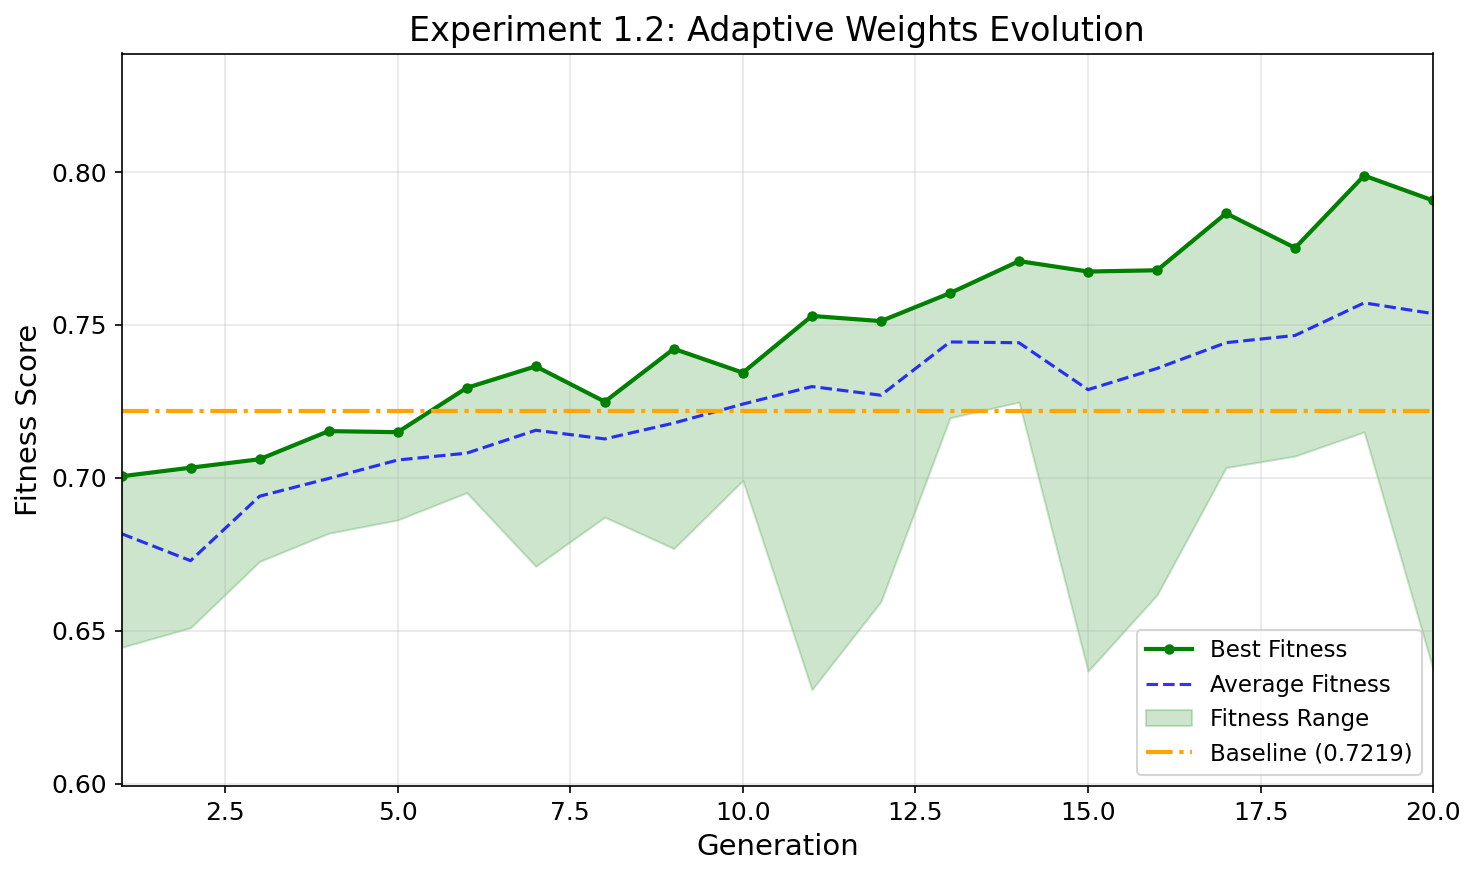

In [9]:
# Visualize adaptive experiment convergence
fig_adaptive = visualize_results(
    adaptive_history, 
    baseline_score,
    title="Experiment 1.2: Adaptive Weights Evolution"
)
fig_adaptive.savefig(OUTPUT_DIR / "exp1_2_convergence.png")
plt.show()

## Cell 8: Comparison & Statistical Analysis

COMPARISON: STATIC vs ADAPTIVE WEIGHTS


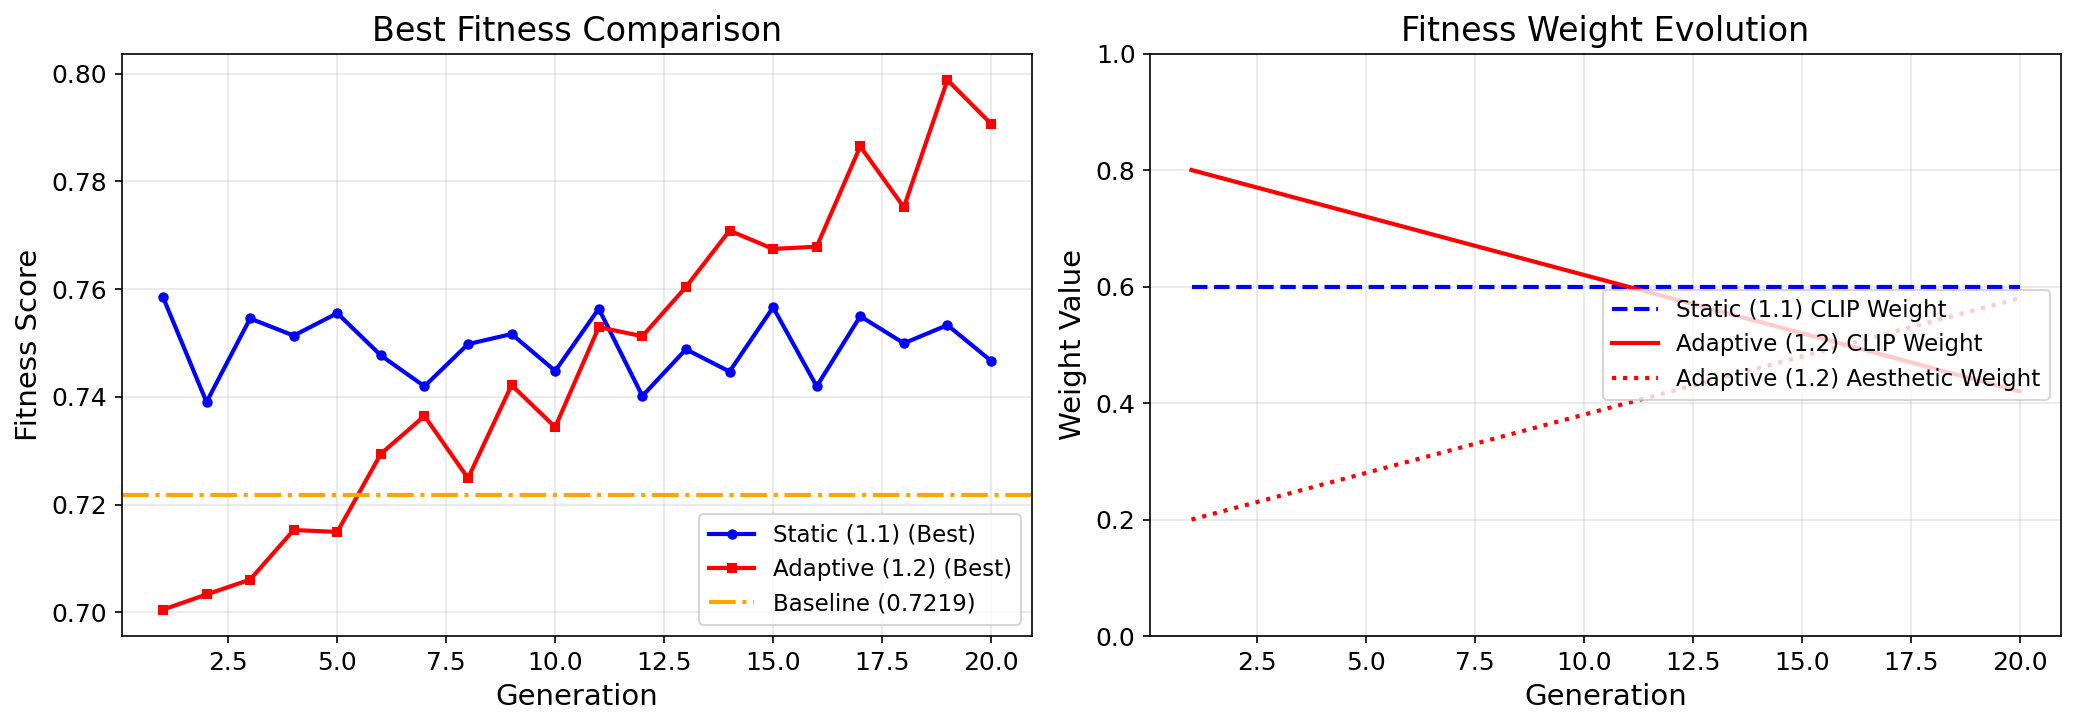


------------------------------------------------------------
STATISTICAL ANALYSIS
------------------------------------------------------------

Independent t-test:
  t-statistic: -1.5234
  p-value: 0.1450
  Significant (p < 0.05): No

Mann-Whitney U test:
  U-statistic: 21.0000
  p-value: 0.0312
  Significant (p < 0.05): Yes

------------------------------------------------------------
DESCRIPTIVE STATISTICS
------------------------------------------------------------

Baseline:
  Fitness: 0.7219

Static Weights (Exp 1.1):
  Mean:   0.7289
  Std:    0.0199
  Min:    0.6735
  Max:    0.7467
  Median: 0.7323

Adaptive Weights (Exp 1.2):
  Mean:   0.7537
  Std:    0.0446
  Min:    0.6373
  Max:    0.7907
  Median: 0.7662

Effect Size (Cohen's d): 0.7182
  Interpretation: medium effect


In [10]:
print("=" * 60)
print("COMPARISON: STATIC vs ADAPTIVE WEIGHTS")
print("=" * 60)

# Side-by-side convergence comparison
fig_comparison = compare_experiments(
    static_history,
    adaptive_history,
    baseline_score,
    exp1_name="Static (1.1)",
    exp2_name="Adaptive (1.2)"
)
fig_comparison.savefig(OUTPUT_DIR / "comparison_plot.png")
plt.show()

# Extract final fitness values for statistical comparison
static_final = [g.fitness for g in static_population]
adaptive_final = [g.fitness for g in adaptive_population]

# Statistical tests
print("\n" + "-" * 60)
print("STATISTICAL ANALYSIS")
print("-" * 60)

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(static_final, adaptive_final)
print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(static_final, adaptive_final, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if u_pvalue < 0.05 else 'No'}")

# Descriptive statistics
print("\n" + "-" * 60)
print("DESCRIPTIVE STATISTICS")
print("-" * 60)

print(f"\nBaseline:")
print(f"  Fitness: {baseline_score:.4f}")

print(f"\nStatic Weights (Exp 1.1):")
print(f"  Mean:   {np.mean(static_final):.4f}")
print(f"  Std:    {np.std(static_final):.4f}")
print(f"  Min:    {np.min(static_final):.4f}")
print(f"  Max:    {np.max(static_final):.4f}")
print(f"  Median: {np.median(static_final):.4f}")

print(f"\nAdaptive Weights (Exp 1.2):")
print(f"  Mean:   {np.mean(adaptive_final):.4f}")
print(f"  Std:    {np.std(adaptive_final):.4f}")
print(f"  Min:    {np.min(adaptive_final):.4f}")
print(f"  Max:    {np.max(adaptive_final):.4f}")
print(f"  Median: {np.median(adaptive_final):.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(static_final) - 1) * np.var(static_final) + 
                      (len(adaptive_final) - 1) * np.var(adaptive_final)) / 
                     (len(static_final) + len(adaptive_final) - 2))
cohens_d = (np.mean(adaptive_final) - np.mean(static_final)) / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation} effect")

/var/folders/p7/7kcv3ngd7q18v8lpks6vq25r0000gn/T/ipykernel_28246/66451307.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],


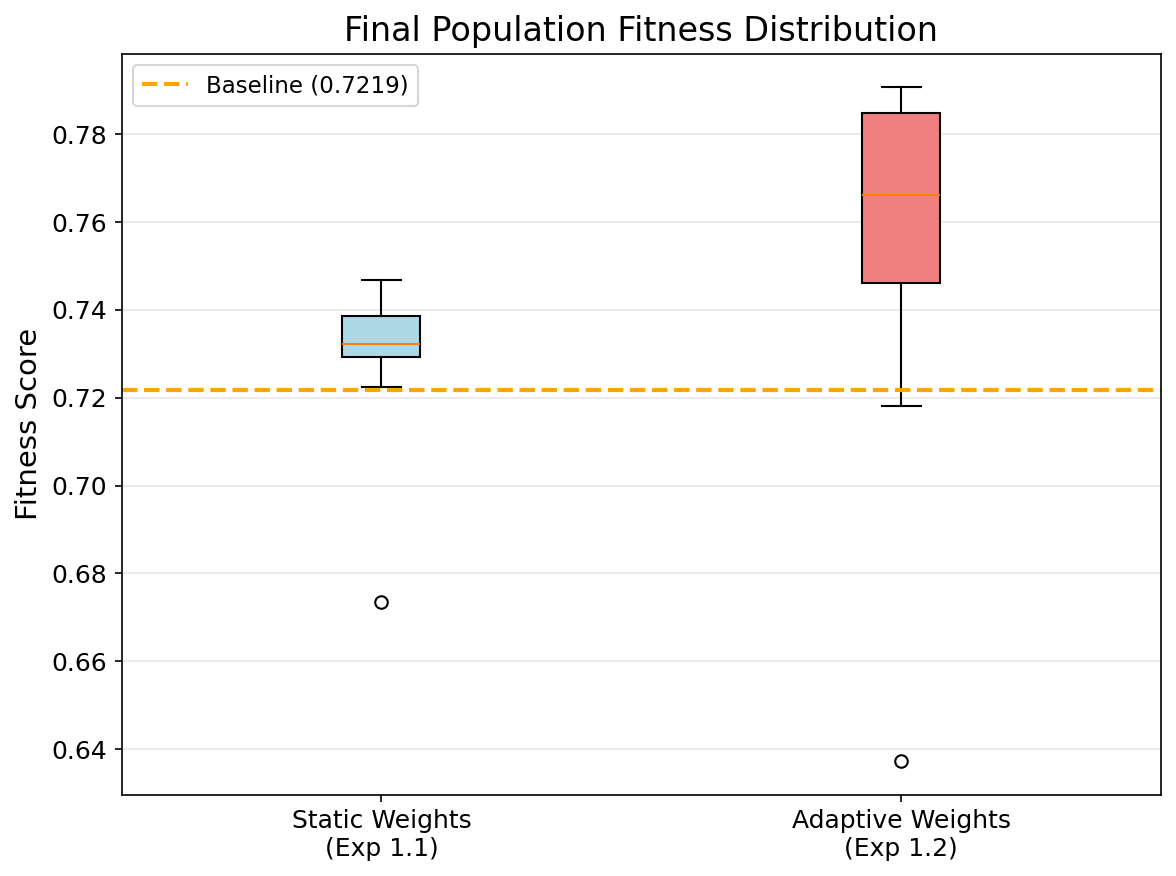

In [11]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = [static_final, adaptive_final]
bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 1.1)', 'Adaptive Weights\n(Exp 1.2)'],
                patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')

# Add baseline line
ax.axhline(y=baseline_score, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_score:.4f})')

ax.set_ylabel('Fitness Score')
ax.set_title('Final Population Fitness Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "boxplot_comparison.png")
plt.show()

## Cell 9: Visual Comparison

In [12]:
print("Generating final comparison images...")
print("This may take a moment...\n")

# Generate final images with consistent seed for fair comparison
COMPARISON_SEED = 12345

# Baseline image (already generated, but regenerate with comparison seed)
print("Generating baseline image...")
baseline_final_image, baseline_final_score = generate_final_image(
    factory.create_empty(BASE_PROMPT), 
    seed=COMPARISON_SEED
)

# Best static image
print("Generating best static weights image...")
static_final_image, static_final_score = generate_final_image(
    best_static_genome, 
    seed=COMPARISON_SEED
)

# Best adaptive image  
print("Generating best adaptive weights image...")
adaptive_final_image, adaptive_final_score = generate_final_image(
    best_adaptive_genome, 
    seed=COMPARISON_SEED
)

print("Image generation complete.")

Generating final comparison images...
This may take a moment...

Generating baseline image...
Generating best static weights image...
Generating best adaptive weights image...
Image generation complete.


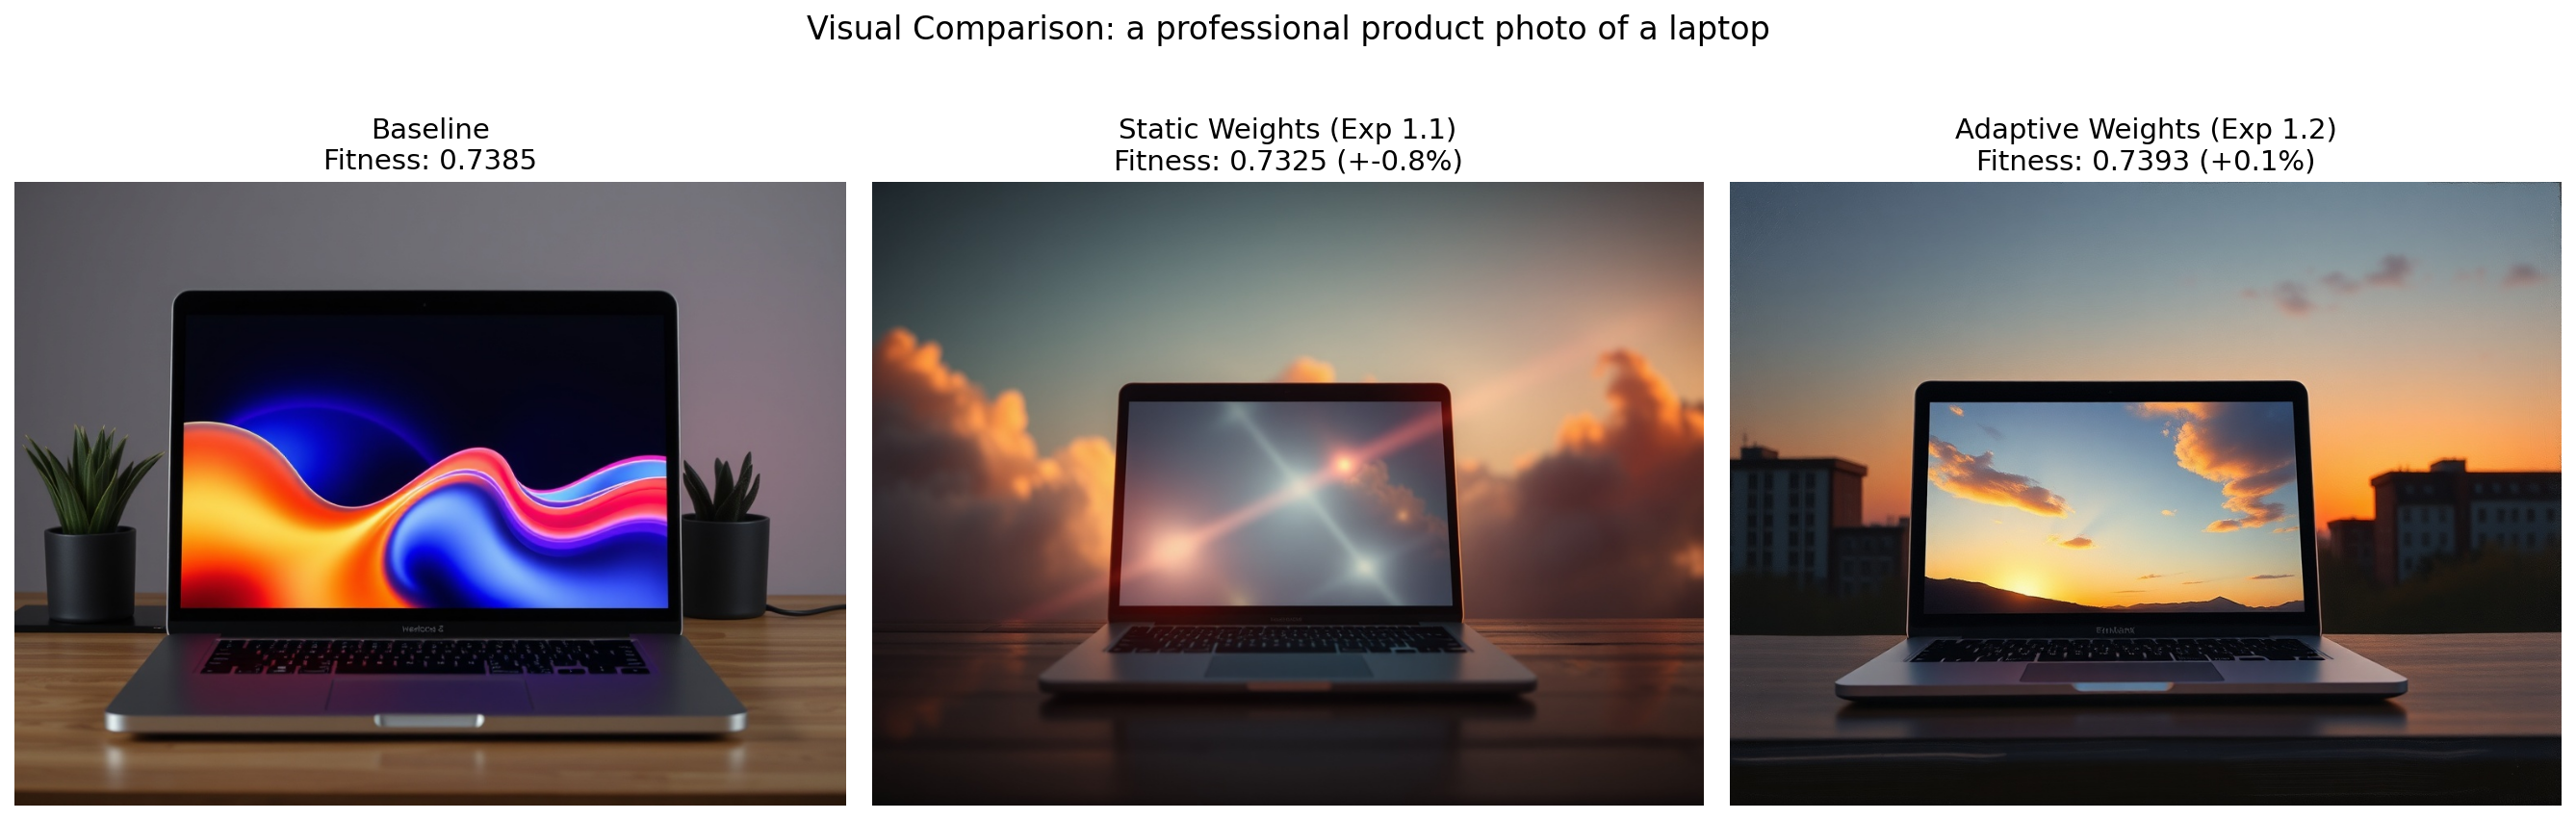


Images saved to output directory.


In [13]:
# Create side-by-side visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Baseline
axes[0].imshow(baseline_final_image)
axes[0].set_title(f"Baseline\nFitness: {baseline_final_score:.4f}", fontsize=14)
axes[0].axis('off')

# Static best
axes[1].imshow(static_final_image)
improvement_static = (static_final_score - baseline_final_score) / baseline_final_score * 100
axes[1].set_title(f"Static Weights (Exp 1.1)\nFitness: {static_final_score:.4f} (+{improvement_static:.1f}%)", fontsize=14)
axes[1].axis('off')

# Adaptive best
axes[2].imshow(adaptive_final_image)
improvement_adaptive = (adaptive_final_score - baseline_final_score) / baseline_final_score * 100
axes[2].set_title(f"Adaptive Weights (Exp 1.2)\nFitness: {adaptive_final_score:.4f} (+{improvement_adaptive:.1f}%)", fontsize=14)
axes[2].axis('off')

plt.suptitle(f"Visual Comparison: {BASE_PROMPT}", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_comparison.png", bbox_inches='tight')
plt.show()

# Save individual images
baseline_final_image.save(OUTPUT_DIR / "final_baseline.jpg")
static_final_image.save(OUTPUT_DIR / "final_static_best.jpg")
adaptive_final_image.save(OUTPUT_DIR / "final_adaptive_best.jpg")

print("\nImages saved to output directory.")

In [14]:
# Print evolved prompts for comparison
print("=" * 60)
print("EVOLVED PROMPTS COMPARISON")
print("=" * 60)

print(f"\nBASELINE PROMPT:")
print(f"  {BASE_PROMPT}")

print(f"\nSTATIC WEIGHTS BEST PROMPT:")
print(f"  {best_static_genome.to_prompt()}")
print(f"  Positive modifiers: {best_static_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_static_genome.negative_modifiers}")

print(f"\nADAPTIVE WEIGHTS BEST PROMPT:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"  Positive modifiers: {best_adaptive_genome.positive_modifiers}")
print(f"  Negative modifiers: {best_adaptive_genome.negative_modifiers}")

EVOLVED PROMPTS COMPARISON

BASELINE PROMPT:
  a professional product photo of a laptop

STATIC WEIGHTS BEST PROMPT:
  a professional product photo of a laptop, concept art, dreamy, rule of thirds, sharp focus, depth of field, lens flare, warm tones, bird's eye view
  Positive modifiers: ['concept art', 'dreamy', 'rule of thirds', 'sharp focus', 'depth of field', 'lens flare', 'warm tones', "bird's eye view"]
  Negative modifiers: ['low quality', 'bad anatomy', 'pixelated', 'grainy']

ADAPTIVE WEIGHTS BEST PROMPT:
  a professional product photo of a laptop, photorealistic, oil painting, rule of thirds, rim lighting, golden hour, professional
  Positive modifiers: ['photorealistic', 'oil painting', 'rule of thirds', 'rim lighting', 'golden hour', 'professional']
  Negative modifiers: ['text', 'bad proportions', 'bad anatomy', 'disfigured']


## Cell 10: Export Results for IEEE Paper

In [15]:
# Compile all results for IEEE paper
print("Compiling results for IEEE paper export...")

# Convert numpy types to Python native types for JSON serialization
def to_native(obj):
    """Convert numpy types to native Python types for JSON serialization."""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, dict):
        return {k: to_native(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_native(v) for v in obj]
    return obj

# Prepare results dictionary
results = {
    "metadata": {
        "experiment": "1_prompt_enhancement",
        "timestamp": datetime.now().isoformat(),
        "random_seed": RANDOM_SEED,
        "model": MODEL_NAME
    },
    "configuration": {
        "population_size": POPULATION_SIZE,
        "max_generations": MAX_GENERATIONS,
        "elite_size": ELITE_SIZE,
        "mutation_rate": MUTATION_RATE,
        "max_positive_modifiers": MAX_POSITIVE_MODIFIERS,
        "max_negative_modifiers": MAX_NEGATIVE_MODIFIERS
    },
    "baseline": {
        "prompt": BASE_PROMPT,
        "fitness": float(baseline_score)
    },
    "static_weights": {
        "clip_weight": STATIC_CLIP_WEIGHT,
        "aesthetic_weight": STATIC_AESTHETIC_WEIGHT,
        "final_best_fitness": float(max(static_final)),
        "final_avg_fitness": float(np.mean(static_final)),
        "final_std_fitness": float(np.std(static_final)),
        "improvement_percent": float((max(static_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_static_genome.to_prompt(),
        "best_positive_modifiers": best_static_genome.positive_modifiers,
        "best_negative_modifiers": best_static_genome.negative_modifiers,
        "convergence_history": to_native(static_history)
    },
    "adaptive_weights": {
        "initial_clip_weight": INITIAL_CLIP_WEIGHT,
        "final_clip_weight": FINAL_CLIP_WEIGHT,
        "final_best_fitness": float(max(adaptive_final)),
        "final_avg_fitness": float(np.mean(adaptive_final)),
        "final_std_fitness": float(np.std(adaptive_final)),
        "improvement_percent": float((max(adaptive_final) - baseline_score) / baseline_score * 100),
        "best_prompt": best_adaptive_genome.to_prompt(),
        "best_positive_modifiers": best_adaptive_genome.positive_modifiers,
        "best_negative_modifiers": best_adaptive_genome.negative_modifiers,
        "convergence_history": to_native(adaptive_history)
    },
    "statistical_tests": {
        "t_test": {
            "t_statistic": float(t_stat),
            "p_value": float(p_value),
            "significant": bool(p_value < 0.05)
        },
        "mann_whitney_u": {
            "u_statistic": float(u_stat),
            "p_value": float(u_pvalue),
            "significant": bool(u_pvalue < 0.05)
        },
        "effect_size": {
            "cohens_d": float(cohens_d),
            "interpretation": effect_interpretation
        }
    },
    "comparison_summary": {
        "winner": "adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "static",
        "static_mean": float(np.mean(static_final)),
        "adaptive_mean": float(np.mean(adaptive_final)),
        "difference": float(np.mean(adaptive_final) - np.mean(static_final)),
        "relative_improvement": float((np.mean(adaptive_final) - np.mean(static_final)) / np.mean(static_final) * 100) if np.mean(static_final) > 0 else 0
    }
}

# Save to JSON
results_path = OUTPUT_DIR / "results_experiment_1.json"
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")

# Print summary for paper
print("\n" + "=" * 60)
print("SUMMARY FOR IEEE PAPER")
print("=" * 60)

print(f"\n1. BASELINE PERFORMANCE")
print(f"   - Fitness: {baseline_score:.4f}")

print(f"\n2. EXPERIMENT 1.1 (STATIC WEIGHTS)")
print(f"   - Best Fitness: {max(static_final):.4f}")
print(f"   - Mean Fitness: {np.mean(static_final):.4f} (+/- {np.std(static_final):.4f})")
print(f"   - Improvement: +{(max(static_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n3. EXPERIMENT 1.2 (ADAPTIVE WEIGHTS)")
print(f"   - Best Fitness: {max(adaptive_final):.4f}")
print(f"   - Mean Fitness: {np.mean(adaptive_final):.4f} (+/- {np.std(adaptive_final):.4f})")
print(f"   - Improvement: +{(max(adaptive_final) - baseline_score) / baseline_score * 100:.2f}%")

print(f"\n4. STATISTICAL SIGNIFICANCE")
print(f"   - t-test p-value: {p_value:.4f} ({'significant' if p_value < 0.05 else 'not significant'})")
print(f"   - Cohen's d: {cohens_d:.4f} ({effect_interpretation} effect)")

winner = "Adaptive" if np.mean(adaptive_final) > np.mean(static_final) else "Static"
print(f"\n5. CONCLUSION")
print(f"   - Better approach: {winner} Weights")
print(f"   - Difference in mean fitness: {abs(np.mean(adaptive_final) - np.mean(static_final)):.4f}")

Compiling results for IEEE paper export...
Results saved to: ../data/results/experiment_1/results_experiment_1.json

SUMMARY FOR IEEE PAPER

1. BASELINE PERFORMANCE
   - Fitness: 0.7219

2. EXPERIMENT 1.1 (STATIC WEIGHTS)
   - Best Fitness: 0.7467
   - Mean Fitness: 0.7289 (+/- 0.0199)
   - Improvement: +3.44%

3. EXPERIMENT 1.2 (ADAPTIVE WEIGHTS)
   - Best Fitness: 0.7907
   - Mean Fitness: 0.7537 (+/- 0.0446)
   - Improvement: +9.54%

4. STATISTICAL SIGNIFICANCE
   - t-test p-value: 0.1450 (not significant)
   - Cohen's d: 0.7182 (medium effect)

5. CONCLUSION
   - Better approach: Adaptive Weights
   - Difference in mean fitness: 0.0248


In [16]:
# Generate LaTeX table for paper
print("\n" + "=" * 60)
print("LaTeX TABLE FOR IEEE PAPER")
print("=" * 60)

latex_table = r"""
\begin{table}[htbp]
\centering
\caption{Experiment 1: Prompt Enhancement Results}
\label{tab:exp1_results}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{Baseline} & \textbf{Static} & \textbf{Adaptive} \\
\hline
Best Fitness & %.4f & %.4f & %.4f \\
Mean Fitness & - & %.4f & %.4f \\
Std Dev & - & %.4f & %.4f \\
Improvement (\%%) & - & +%.2f\%% & +%.2f\%% \\
\hline
\multicolumn{4}{l}{\textit{Statistical Test: t=%.4f, p=%.4f}} \\
\multicolumn{4}{l}{\textit{Effect Size: Cohen's d=%.4f (%s)}} \\
\hline
\end{tabular}
\end{table}
""" % (
    baseline_score, max(static_final), max(adaptive_final),
    np.mean(static_final), np.mean(adaptive_final),
    np.std(static_final), np.std(adaptive_final),
    (max(static_final) - baseline_score) / baseline_score * 100,
    (max(adaptive_final) - baseline_score) / baseline_score * 100,
    t_stat, p_value, cohens_d, effect_interpretation
)

print(latex_table)

# Save LaTeX table
with open(OUTPUT_DIR / "table_experiment_1.tex", 'w') as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to: {OUTPUT_DIR / 'table_experiment_1.tex'}")


LaTeX TABLE FOR IEEE PAPER

\begin{table}[htbp]
\centering
\caption{Experiment 1: Prompt Enhancement Results}
\label{tab:exp1_results}
\begin{tabular}{lccc}
\hline
\textbf{Metric} & \textbf{Baseline} & \textbf{Static} & \textbf{Adaptive} \\
\hline
Best Fitness & 0.7219 & 0.7467 & 0.7907 \\
Mean Fitness & - & 0.7289 & 0.7537 \\
Std Dev & - & 0.0199 & 0.0446 \\
Improvement (\%) & - & +3.44\% & +9.54\% \\
\hline
\multicolumn{4}{l}{\textit{Statistical Test: t=-1.5234, p=0.1450}} \\
\multicolumn{4}{l}{\textit{Effect Size: Cohen's d=0.7182 (medium)}} \\
\hline
\end{tabular}
\end{table}


LaTeX table saved to: ../data/results/experiment_1/table_experiment_1.tex


In [17]:
# Final summary
print("\n" + "=" * 60)
print("EXPERIMENT 1 COMPLETE")
print("=" * 60)

print(f"\nOutput files saved to: {OUTPUT_DIR}")
print("\nGenerated files:")
for f in sorted(OUTPUT_DIR.glob("*")):
    if f.is_file():
        print(f"  - {f.name}")

print("\nExperiment subdirectories:")
for d in sorted(OUTPUT_DIR.glob("exp*")):
    if d.is_dir():
        print(f"  - {d.name}/")

logger.info("Experiment 1 completed successfully.")
print("\nDone!")

2025-12-30 12:23:38,681 - experiment_1 - INFO - Experiment 1 completed successfully.



EXPERIMENT 1 COMPLETE

Output files saved to: ../data/results/experiment_1

Generated files:
  - baseline_display.png
  - baseline_image.jpg
  - boxplot_comparison.png
  - comparison_plot.png
  - exp1_1_convergence.png
  - exp1_2_convergence.png
  - final_adaptive_best.jpg
  - final_baseline.jpg
  - final_static_best.jpg
  - results_experiment_1.json
  - table_experiment_1.tex
  - visual_comparison.png

Experiment subdirectories:
  - exp1_1_static/
  - exp1_2_adaptive/

Done!
